In [1]:
# common imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pandas imports
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split

# display setup
pd.set_option("display.max_columns", None) # the None parameter displays unlimited columns
sns.set(style="whitegrid") # for plots

## 1. Getting the Data

In [2]:
# read the csv file
df = pd.read_csv("udemy_courses.csv")

In [3]:
# display the first 5 rows for a quick look
df.head()

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance


In [4]:
# DataFrame shape (rows, columns)
# understand the amount of data we are working with
df.shape

(3678, 12)

In [5]:
# description of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3678 non-null   int64  
 1   course_title         3678 non-null   object 
 2   url                  3678 non-null   object 
 3   is_paid              3678 non-null   bool   
 4   price                3678 non-null   int64  
 5   num_subscribers      3678 non-null   int64  
 6   num_reviews          3678 non-null   int64  
 7   num_lectures         3678 non-null   int64  
 8   level                3678 non-null   object 
 9   content_duration     3678 non-null   float64
 10  published_timestamp  3678 non-null   object 
 11  subject              3678 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 319.8+ KB


In [6]:
# check if there are null values
df.isna().sum()

course_id              0
course_title           0
url                    0
is_paid                0
price                  0
num_subscribers        0
num_reviews            0
num_lectures           0
level                  0
content_duration       0
published_timestamp    0
subject                0
dtype: int64

In [7]:
# summary of the numerical attributes
df.describe()

,course_id,price,num_subscribers,num_reviews,num_lectures,content_duration
count,3.678000e+03,3678.000000,3678.000000,3678.000000,3678.000000,3678.000000
mean,6.759720e+05,66.049483,3197.150625,156.259108,40.108755,4.094517
std,3.432732e+05,61.005755,9504.117010,935.452044,50.383346,6.053840
min,8.324000e+03,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.076925e+05,20.000000,111.000000,4.000000,15.000000,1.000000
50%,6.879170e+05,45.000000,911.500000,18.000000,25.000000,2.000000
75%,9.613555e+05,95.000000,2546.000000,67.000000,45.750000,4.500000
max,1.282064e+06,200.000000,268923.000000,27445.000000,779.000000,78.500000


> As shown above, there are no missing values which is excellent!
>
> *It is vital to understand the features we are working with.*
> ### Features in the DataFrame:
>> 1. course_id: Course identification number
>> 2. course_title: Title of course
>> 3. url: Course URL
>> 4. is_paid: True if the course costs money, False if the course is free
>> 5. price: Price of course
>> 6. num_subscribers: Number of subscribers for the course
>> 7. num_lectures: Number of lectures in the course
>> 8. level: Difficulty level of the course
>> 9. content_duration: Duration of all course materials
>> 10. published_timestamp: Course publication date
>> 11. subject: Subject of course

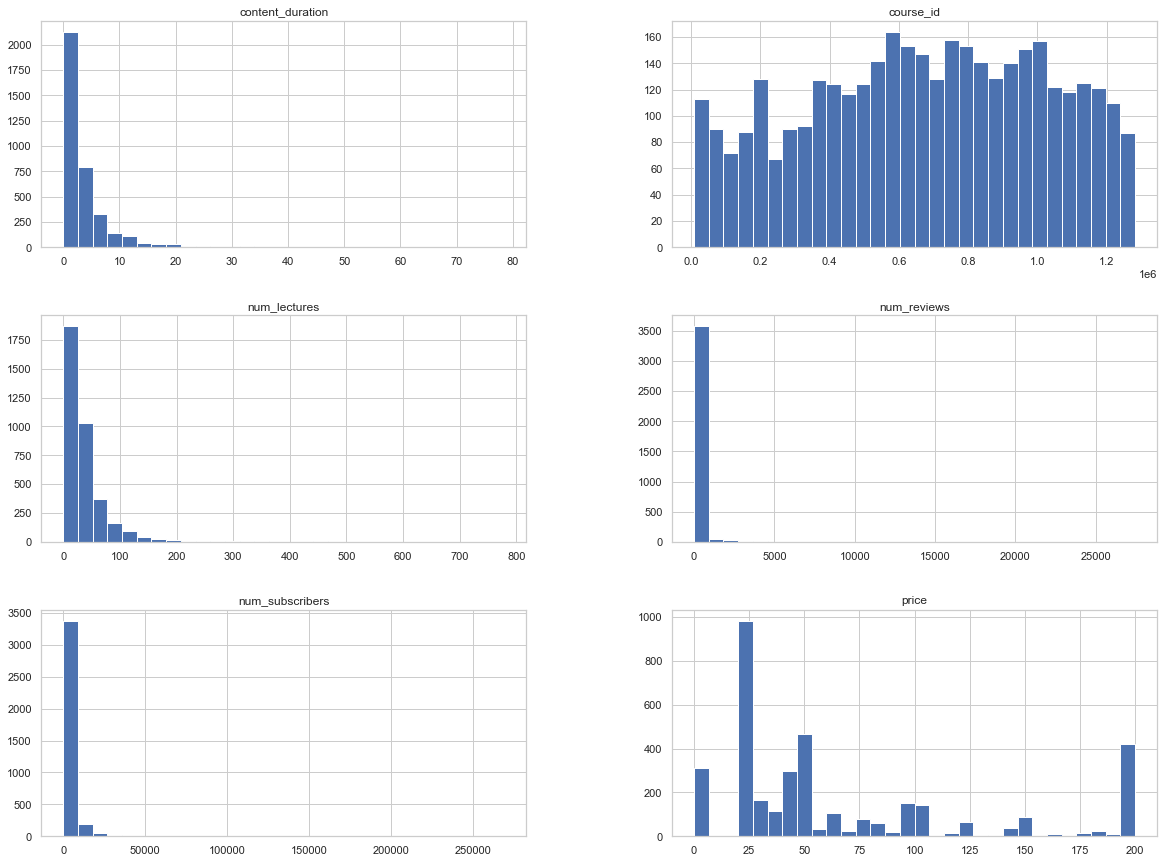

In [8]:
# a histogram plot for each numerical attribute
df.drop("is_paid", axis=1).hist(bins=30, figsize=(20,15))
# plt.tight_layout()
plt.show()

> Initial observations from the histograms:
>> 1. Most course durations are between 0-5 hours.
>> 2. There are usually around 1-50 lectures per course.
>> 3. Courses tend to have few reviews. There are probably a handful of courses
>> with a large amount of reviews since the X axis goes up to 25000 while over 3000
>> instances are represented in the first bin.
>> 4. The majority of courses are in the same range of subscribers. The instances farther up
>> the scale were probably more successful or perhaps courses on a trending topic.
>> 5. Assuming the prices are in USD, the range is between 0-250 dollars.
>> The plot shows the most common price roughly $25.
>>
>> It would probably be a good idea to look further into some of these values.
>> For instance, if the content duration or number of lectures is listed as 0.

> ### Objective:
> #### Predicting the number of subscribers for a course.
>> ##### Chosen Feature:
>> *num_subscribers column*
>>> The column represents how many people have subscribed for each individual course.
>>> ##### Motive:
>>> Predicting the number of people interested in a course. The more subscribers, the
>>> more popular the course.

> #### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

In [9]:
# use sklearn train_test_split function to split the data
# the random state parameter ensures that data will be shuffled and split the same way in each run
train_set, test_set = train_test_split(df, test_size=0.20, random_state=42)

In [10]:
print("Number of instances in training set: ", len(train_set))
print("Number of instances in testing set: ", len(test_set))

Number of instances in training set:  2942
Number of instances in testing set:  736


## 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights*

In [11]:
# deep copy of the training set
df2 = train_set.copy()

In [12]:
df2.head(2)

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
2490,1146014,Learn JavaScript for beginners,https://www.udemy.com/learn-javascript-course/,True,200,15276,167,19,Beginner Level,1.5,2017-03-16T20:57:12Z,Web Development
2886,241590,Make a professional website - 30 Day Guarantee...,https://www.udemy.com/make-your-own-business-w...,True,20,11167,34,13,All Levels,2.0,2014-06-23T16:03:41Z,Web Development


> ## Exploring Attribute Combinations

In [13]:
# method creates a correlations matrix
corr_matrix = df2.corr()

In [14]:
# looking at attributes correlation with num_subscribers feature
corr_matrix["num_subscribers"].sort_values(ascending=False)

num_subscribers     1.000000
num_reviews         0.641087
num_lectures        0.164072
content_duration    0.161800
price               0.046734
course_id          -0.168235
is_paid            -0.270822
Name: num_subscribers, dtype: float64